<a href="https://colab.research.google.com/github/mst-projects/numerai/blob/main/train_LassoLarsIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import gc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Read training data

In [ ]:
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.50,1.00,0.50,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.50,0.50,0.75,0.50,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.50,0.25,0.25,0.75,0.50,1.00,0.50,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.50,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.00,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.50,0.25,0.75,0.50,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.00,0.25,1.00,0.50,1.00,1.00,0.50,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.50,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,0.25,0.00,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.50,0.50,0.75,0.50,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.50,1.00,0.00,1.00,1.00,0.50,1.00,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.00,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.00,0.50,0.50,0.00,1.00,0.00,0.75,0.00,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,0.75,1.00,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.50,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.00,0.50,0.50,0.25,0.00,0.50,0.00,0.50,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.50,1.00,0.50,0.75,0.25,0.50,0.00,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.50,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,nff6a8a8feaeeb52,era120,train,0.50,0.50,0.25,0.00,0.00,0.50,0.75,0.00,0.75,0.75,0.25,0.00,1.00,0.00,0.75,0.00,0.50,1.00,0.25,0.25,0.00,0.50,0.75,0.

In [ ]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]

In [ ]:
TOURNAMENT_NAME = ""
TARGET_NAME = f"target{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction{TOURNAMENT_NAME}"
train_features = training_data[feature_names]
train_target = training_data[TARGET_NAME]

## Training model LassoLarsIC

In [ ]:
from sklearn.linear_model import  LassoLarsIC
model = LassoLarsIC(criterion='aic', normalize=True)
model.fit(train_features, train_target)

LassoLarsIC(normalize=True)

In [ ]:
# import pickle
# pickle.dump(model, open("", "wb"))

In [ ]:
del training_data
gc.collect()

113

## Read tournament data

In [ ]:
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.00,0.75,0.50,0.25,0.50,0.50,0.25,0.00,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.00,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.00,0.25,0.50,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.50,0.00,0.00,0.75,0.25,0.00,0.75,0.50,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.00,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.50,0.25,1.00,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.50,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00,1.00,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.50,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.50,0.00,0.00,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.00,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.00,0.00,0.00,0.50,0.75,1.00,0.75,0.00,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.00,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.00,0.50,0.50,0.25,0.25,0.50,0.50,1.00,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.00,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.50,0.50,0.00,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.00,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.00,0.0,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886706,nffad5892c45c8b1,eraX,live,0.75,0.50,0.50,0.50,1.00,0.50,0.50,0.25,0.25,0.25,0.75,1.00,0.50,0.00,0.00,0.75,0.50,0.25

## Set validation data

In [ ]:
validation_data = tournament_data[tournament_data['data_type'] == 'validation']
validation_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.00,0.75,0.50,0.25,0.50,0.50,0.25,0.00,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.00,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.50,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.00,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.50,0.00,0.00,0.75,0.25,0.00,0.75,0.50,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.00,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.00,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.50,0.50,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00,1.00,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.50,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.00,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.00,0.50,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.00,0.00,0.00,0.50,0.75,1.00,0.75,0.00,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.00,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.00,0.50,0.50,0.25,0.25,0.50,0.50,1.00,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.00,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.00,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.00,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.00,0.00,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545360,nffb61f786fe2a96,era212,validation,0.00,0.50,0.75,0.00,0.50,0.50,0.50,0.00,0.50,0.75,0.25,0.50,1.00,0.50,0.50,0.25,0

In [ ]:
del tournament_data
gc.collect()

62

## Prediction

In [ ]:
predictions = model.predict(validation_data[feature_names])
validation_data[PREDICTION_NAME] = predictions

## Validation

In [ ]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def sharpe(x):
    return np.mean(x)/np.std(x, ddof=1)

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def sortino_ratio(x, target=0.010415154):
   xt = x# - target
   return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5

def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]

In [ ]:
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

On validation the correlation has mean 0.01627135225979023 and std 0.0323863336040949


In [ ]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.5024141497058159
smart sharpe:  0.47130705593257877
sortino_ratio:  0.9380662036094572


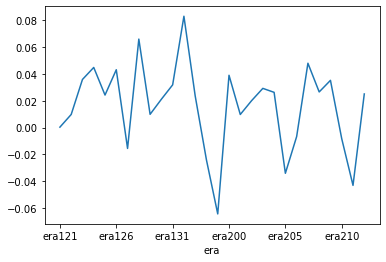

In [ ]:
print(validation_correlations)
validation_correlations.plot()

## Neutralization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

In [ ]:
import scipy
validation_data["preds"] = predictions
validation_data["preds_neutralized"] = validation_data.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], feature_names, 0.5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
validation_data["preds_neutralized"] = scaler.fit_transform(validation_data[["preds_neutralized"]]) # transform back to 0-1

## Validation on newtralization

In [ ]:
validation_data[PREDICTION_NAME] = validation_data['preds_neutralized']
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

On validation the correlation has mean 0.01654417665014807 and std 0.031847646471326554


In [ ]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.519478783621996
smart sharpe:  0.49720809378995545
sortino_ratio:  0.9737756098203176


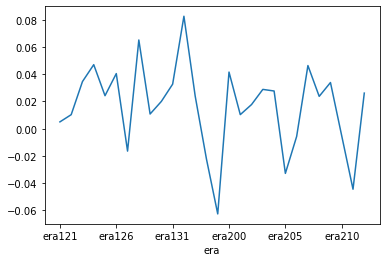

In [ ]:
validation_correlations.plot()